# Module and Function

In [11]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import random


import os
import time
import datetime
import calendar

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold


from sklearn import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score


# from utils_model import * # expand later

In [2]:
def fast_build_model_FE_SW(X,y,cv,Feature_Engineering,parameters,model_base=LogisticRegression(class_weight='balanced'),SW=[],random_state=0,shuffle=False):

    num_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy = 'median')),
                                    ('scaler', RobustScaler())
                                    ])

    cat_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                    ])

    


    
    
    skf = StratifiedKFold(n_splits=cv,random_state = random_state,shuffle = shuffle)


    # oof validation
    oof_y_valid = []
    oof_y_valid_pred = []
    oof_y_valid_pred_proba = []
    pipelines = []
    add_fes = []
    data = pd.concat([X,y],axis=1)
    aucs=[]
    predictions = np.zeros(len(y))
    for cv,(train_index, val_index) in enumerate(skf.split(X,y)):
        start_fit = time.time()
        data_train = data.iloc[train_index,:].copy()
        
        add_fe = Feature_Engineering(parameters)
        add_fe.fit(data_train)
        
        X_train = add_fe.transform(data_train).drop(columns=[parameters['target']])
        y_train = y.iloc[train_index]
        X_val = add_fe.transform(X.iloc[val_index,:],mode='val')
        y_val = y.iloc[val_index]
        
        num_cols_fe = list(X_train.select_dtypes(exclude='object').columns)
        cat_cols_fe = list(X_train.select_dtypes(include='object').columns)        
        
#         print(X_train.shape,X_val.shape,data.shape)
        
        transformer = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols_fe),
            ('cat', cat_transformer, cat_cols_fe)
        ])
        
        main_pipeline = Pipeline(steps=[('transformer', transformer),
                          ('classifier', model_base)])
        

        

        add_fes.append(add_fe)
        model = clone(main_pipeline)
        
        if len(SW)!=0:
            kwargs = {main_pipeline.steps[-1][0] + '__sample_weight': SW[train_index]}
            model.fit(X_train,y_train.values.ravel(),**kwargs)
        else:
            model.fit(X_train,y_train.values.ravel())
        pred = model.predict(X_val)
        pred_proba = model.predict_proba(X_val)[:,1]
        predictions[val_index] = pred_proba
        oof_y_valid_pred.extend(pred)
        oof_y_valid_pred_proba.extend(pred_proba)
        oof_y_valid.extend(y_val.values)
        aucs.append(roc_auc_score(y_val.values, pred_proba,average='weighted'))
        pipelines.append(model)
        print(f'Fit iteration {cv} done in : {str(time.time()-start_fit)}')

    prec,rec,f1, _ = precision_recall_fscore_support(oof_y_valid,oof_y_valid_pred)
    auc = roc_auc_score(oof_y_valid, oof_y_valid_pred_proba,average='weighted')
    print(f'PRec Rec AUC average : {prec} {rec} <==> {auc}')
    print(aucs)
    print(np.mean(aucs[:2]))
    return add_fes,pipelines,predictions



def fast_build_model_FE_1(X,y,Feature_Engineering,parameters,model_base=LogisticRegression(class_weight='balanced'),SW=[],random_state=0,shuffle=False):

    num_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy = 'median')),
                                    ('scaler', RobustScaler())
                                    ])

    cat_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                    ])
    data = pd.concat([X,y],axis=1)
    aucs=[]
    start_fit = time.time()
    data_train = data.copy()
    add_fe = Feature_Engineering(parameters)
    add_fe.fit(data_train)

    X_train = add_fe.transform(data_train).drop(columns=[parameters['target']])
    num_cols_fe = list(X_train.select_dtypes(exclude='object').columns)
    cat_cols_fe = list(X_train.select_dtypes(include='object').columns)

    y_train = y

    
    transformer = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols_fe),
        ('cat', cat_transformer, cat_cols_fe)
    ])

    main_pipeline = Pipeline(steps=[('transformer', transformer),
                      ('classifier', model_base)])



#     add_fes.append(add_fe)
    model = clone(main_pipeline)
    
    if len(SW)!=0:
        kwargs = {main_pipeline.steps[-1][0] + '__sample_weight': SW}
        model.fit(X_train,y_train.values.ravel(),**kwargs)
    else:
        model.fit(X_train,y_train.values.ravel())
    
    return [add_fe],[model]


In [20]:
def fast_predict_FE(data,add_fes,pipelines):
    X = data.copy()
#     pred = np.zeros(1,len(X))
    pred_proba = np.zeros((len(X)))
    dude={}
    for i in range(len(pipelines)):
        
        pred_proba += pipelines[i].predict_proba(add_fes[i].transform(X,mode='test'))[:,1] / len(pipelines)
        dude[i] = pipelines[i].predict_proba(add_fes[i].transform(X,mode='test'))[:,1]
    
    return pred_proba,dude



        

In [28]:
def fast_build_model_FE_automatic_2_pipe(X,y,cv,Feature_Engineering,parameters1,parameters2,model_base=LogisticRegression(class_weight='balanced'),SW=[],random_state=0,shuffle=False):

    num_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy = 'median')),
                                    ('scaler', RobustScaler())
                                    ])

    cat_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                    ])

    


    
    
    skf = StratifiedKFold(n_splits=cv,random_state = 3,shuffle = True)


    # oof validation
    oof_y_valid = []
    oof_y_valid_pred = []
    oof_y_valid_pred_proba = []
    pipelines = []
    add_fes1 = []
    add_fes2 = []
    data = pd.concat([X,y],axis=1)
    aucs=[]
#     print(data.columns)
    for cv,(train_index, val_index) in enumerate(skf.split(X,y)):
        start_fit = time.time()
        data_train = data.iloc[train_index,:].copy()
#         data_val = data.iloc[val_index,:][features]
        
        add_fe1 = Feature_Engineering(parameters1)
        add_fe2 = Feature_Engineering(parameters2)
        add_fe1.fit(data_train)
        
        X_train = add_fe1.transform(data_train)
        add_fe2.fit(X_train)
        X_train = add_fe2.transform(X_train).drop(columns=[parameters1['target']])
        
        num_cols_fe = list(X_train.select_dtypes(exclude='object').columns)
        cat_cols_fe = list(X_train.select_dtypes(include='object').columns)
        

        y_train = y.iloc[train_index]
        
        X_val = add_fe1.transform(X.iloc[val_index,:],mode='val')
        X_val = add_fe2.transform(X_val,mode='val')
        y_val = y.iloc[val_index]
        
        
        transformer = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols_fe),
            ('cat', cat_transformer, cat_cols_fe)
        ])
        
        main_pipeline = Pipeline(steps=[('transformer', transformer),
                          ('classifier', model_base)])
        

        
        add_fes1.append(add_fe1)
        add_fes2.append(add_fe2)
        model = clone(main_pipeline)
        
        if len(SW)!=0:
            kwargs = {main_pipeline.steps[-1][0] + '__sample_weight': SW[train_index]}
            model.fit(X_train,y_train.values.ravel(),**kwargs)
        else:
            model.fit(X_train,y_train.values.ravel())
        
        
        
        pred = model.predict(X_val)
        pred_proba = model.predict_proba(X_val)[:,1]
        oof_y_valid_pred.extend(pred)
        oof_y_valid_pred_proba.extend(pred_proba)
        oof_y_valid.extend(y_val.values)
        aucs.append(roc_auc_score(y_val.values, pred_proba,average='weighted'))
        pipelines.append(model)
        print(f'Fit iteration {cv} done in : {str(time.time()-start_fit)}')

    prec,rec,f1, _ = precision_recall_fscore_support(oof_y_valid,oof_y_valid_pred)
    auc = roc_auc_score(oof_y_valid, oof_y_valid_pred_proba,average='weighted')
    print(f'PRec Rec AUC average : {prec} {rec} <==> {auc}')
    print(np.mean(aucs))
    return add_fes1,add_fes2,pipelines



def fast_build_model_FE_2fe_1(X,y,Feature_Engineering,parameters1,parameters2,model_base=LogisticRegression(class_weight='balanced'),random_state=0,shuffle=False,SW=[]):

    num_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy = 'median')),
                                    ('scaler', RobustScaler())
                                    ])

    cat_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                    ])
    data = pd.concat([X,y],axis=1)
    aucs=[]
    start_fit = time.time()
    data_train = data.copy()
    add_fe1 = Feature_Engineering(parameters1)
    add_fe2 = Feature_Engineering(parameters2)
    
    add_fe1.fit(data_train)
    X_train = add_fe1.transform(data_train)
    add_fe2.fit(X_train)
    X_train = add_fe2.transform(X_train).drop(columns=[parameters1['target']])

    num_cols_fe = list(X_train.select_dtypes(exclude='object').columns)
    cat_cols_fe = list(X_train.select_dtypes(include='object').columns)
    y_train = y


    transformer = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols_fe),
        ('cat', cat_transformer, cat_cols_fe)
    ])

    main_pipeline = Pipeline(steps=[('transformer', transformer),
                      ('classifier', model_base)])



    model = clone(main_pipeline)
    
    if len(SW)!=0:
        kwargs = {main_pipeline.steps[-1][0] + '__sample_weight': SW}
        model.fit(X_train,y_train.values.ravel(),**kwargs)
    else:
        model.fit(X_train,y_train.values.ravel())

    
    
    return [add_fe1],[add_fe2],[model]



def fast_predict_FE_2(data,add_fes1,add_fes2,pipelines):
    X = data.copy()
#     pred = np.zeros(1,len(X))
    pred_proba = np.zeros((len(X)))
    for i in range(len(pipelines)):
        
        pred_proba += pipelines[i].predict_proba(add_fes2[i].transform(add_fes1[i].transform(X,mode='test'),mode='test'))[:,1] / len(pipelines)
    
    return pred_proba

In [4]:
class Feature_Engineering:
    def __init__(self,parameters):
        self.parameters = parameters
        self.target = parameters['target']
    
    @staticmethod  
    def check_col(col):
        if len(col.split(' '))>1:
            col2 = '_'.join(col.split(' '))
        else:
            col2 = col
        return col2
    
    @staticmethod
    def get_bin(data,col,n_bin,mode='cut'):
        while True:
            try:
                if mode=='cut':
                    _,bin_dummy = pd.cut(data[col],n_bin,retbins=True)
                else:
                    _,bin_dummy = pd.qcut(data[col],n_bin,retbins=True)
            except:
                n_bin -= 1
                continue
            break
        return bin_dummy
        
    def fit(self,data_ori):
        target = self.target
        data = data_ori.copy()
        for param in self.parameters['bin_numer_qcut']:
            col = param[0]
            n_bin = param[1]
            bin_dummy = self.get_bin(data,col,n_bin,mode='qcut')
            bin_dummy[0] = bin_dummy[0]-0.001
            bin_dummy[-1] = np.inf
            setattr(self,f'{col}_bin_numer_qcut',bin_dummy)
        for param in self.parameters['bin_numer_cut']:
            col = param[0]
            n_bin = param[1]
            bin_dummy = self.get_bin(data,col,n_bin,mode='cut')
            bin_dummy[0] = bin_dummy[0]-0.001
            bin_dummy[-1] = np.inf
            setattr(self,f'{col}_bin_numer_cut',bin_dummy)
            
            
        for param in self.parameters['bin_add_categ_numer_bin_cut']:
            col = param[1]
            n_bin = param[2]
            bin_dummy = self.get_bin(data,col,n_bin,mode='cut')
            bin_dummy[0] = bin_dummy[0]-0.001
            bin_dummy[-1] = np.inf
            setattr(self,f'{col}_bin_cut_add_categ',bin_dummy)
            
        for param in self.parameters['bin_add_categ_numer_bin_qcut']:
            col = param[1]
            n_bin = param[2]
            bin_dummy = self.get_bin(data,col,n_bin,mode='qcut')
            bin_dummy[0] = bin_dummy[0]-0.001
            bin_dummy[-1] = np.inf
            setattr(self,f'{col}_bin_qcut_add_categ',bin_dummy)
        
        for param in self.parameters['bin_target_encoding_cut']:
            col = param[0]
            n_bin = param[1]
            bin_dummy = self.get_bin(data,col,n_bin,mode='cut')
            bin_dummy[0] = bin_dummy[0]-0.001
            bin_dummy[-1] = np.inf
            setattr(self,f'{col}_bin_cut',bin_dummy)
            
            data[f'{col}_bin_target_encoding_cut'] = pd.cut(data[col],bins=bin_dummy)
            data_dummy = data.groupby([f'{col}_bin_target_encoding_cut'])[target].mean().reset_index(drop=False)
            setattr(self,f'{col}_bin_target_encoding_cut',data_dummy)
            
        for param in self.parameters['bin_target_encoding_qcut']:
            col = param[0]
            n_bin = param[1]
            bin_dummy = self.get_bin(data,col,n_bin,mode='qcut')
            bin_dummy[0] = bin_dummy[0]-0.001
            bin_dummy[-1] = np.inf
            setattr(self,f'{col}_bin_qcut',bin_dummy)
            
            data[f'{col}_bin_target_encoding_qcut'] = pd.cut(data[col],bins=bin_dummy)
            data_dummy = data.groupby([f'{col}_bin_target_encoding_qcut'])[target].mean().reset_index(drop=False)
            setattr(self,f'{col}_bin_target_encoding_qcut',data_dummy)
           
        for param in self.parameters['bin_target_encoding_custom_bin']:
            col = param[0]
            bins = param[1]
            setattr(self,f'{col}_bin_custom_bin',bins)
            
            data[f'{col}_bin_target_encoding_custom_bin'] = pd.cut(data[col],bins=bins)
            data_dummy = data.groupby([f'{col}_bin_target_encoding_custom_bin'])[target].mean().reset_index(drop=False)
            setattr(self,f'{col}_bin_target_encoding_custom_bin',data_dummy)
        
        for param in self.parameters['categorical_mean_encoding']:
            col = param
            data[f'{col}_categorical_mean_encoding'] = data[col].copy().values
            data_dummy = data.groupby([f'{col}_categorical_mean_encoding'])[target].mean().reset_index(drop=False)
            setattr(self,f'{col}_categorical_mean_encoding',data_dummy)
        
        
        
        self.fit = True
        return data
        
    
    def transform(self,X,mode='train'):
        data = X.copy()
        target = self.target
        if mode!='train':
            target_encode = self.target
        else:
            target_encode = self.target +"_y"
            
        if self.fit==False:
            raise Exception("Fit to train data first")
        
        for param in self.parameters['bin_numer_qcut']:
            col = param[0]
            bin_dummy = eval(f'self.{col}_bin_numer_qcut')
            data[f'{col}_bin_numer_qcut'] = pd.cut(data[col],bins=bin_dummy).astype(str).values
        for param in self.parameters['bin_numer_cut']:
            col = param[0]
            bin_dummy = eval(f'self.{col}_bin_numer_cut')
            data[f'{col}_bin_numer_cut'] = pd.cut(data[col],bins=bin_dummy).astype(str).values
            
        for cols in self.parameters['bin_add_categ_numer_bin_cut']:
            col_add = cols[0] + '_' + cols[1]
            bin_dummy = eval(f'self.{cols[1]}_bin_cut_add_categ')
            data[f'{col_add}_bin_add_categ_numer_bin_cut'] = pd.cut(data[cols[1]],bins=bin_dummy).values
            data[f'{col_add}_bin_add_categ_numer_bin_cut'] = (data[cols[0]].astype(str)+'_' + data[f'{col_add}_bin_add_categ_numer_bin_cut'].astype(str)).values
            
        for cols in self.parameters['bin_add_categ_numer_bin_qcut']:
            col_add = cols[0] + '_' + cols[1]
            bin_dummy = eval(f'self.{cols[1]}_bin_qcut_add_categ')
            data[f'{col_add}_bin_add_categ_numer_bin_qcut'] = pd.cut(data[cols[1]],bins=bin_dummy).values
            data[f'{col_add}_bin_add_categ_numer_bin_qcut'] = (data[cols[0]].astype(str)+'_' + data[f'{col_add}_bin_add_categ_numer_bin_qcut'].astype(str)).values
        
        for param in self.parameters['bin_target_encoding_cut']:
            col = param[0]
            bin_dummy = eval(f'self.{col}_bin_cut')
            data_dummy = eval(f'self.{col}_bin_target_encoding_cut')
            data[f'{col}_bin_target_encoding_cut'] = pd.cut(data[col],bins=bin_dummy).values
            data[f'{col}_bin_target_encoding_cut'] = pd.merge(data,data_dummy,how='left',on=[f'{col}_bin_target_encoding_cut'])[f'{target_encode}'].values
        
        for param in self.parameters['bin_target_encoding_qcut']:
            col = param[0]
            bin_dummy = eval(f'self.{col}_bin_qcut')
            data_dummy = eval(f'self.{col}_bin_target_encoding_qcut')
            data[f'{col}_bin_target_encoding_qcut'] = pd.cut(data[col],bins=bin_dummy).values
            data[f'{col}_bin_target_encoding_qcut'] = pd.merge(data,data_dummy,how='left',on=[f'{col}_bin_target_encoding_qcut'])[f'{target_encode}'].values
        
        for param in self.parameters['bin_target_encoding_custom_bin']:
            col = param[0]
            bin_dummy = eval(f'self.{col}_bin_custom_bin')
            data_dummy = eval(f'self.{col}_bin_target_encoding_custom_bin')
            data[f'{col}_bin_target_encoding_custom_bin'] = pd.cut(data[col],bins=bin_dummy).values
            data[f'{col}_bin_target_encoding_custom_bin'] = pd.merge(data,data_dummy,how='left',on=[f'{col}_bin_target_encoding_custom_bin'])[f'{target_encode}'].values
        
        for param in self.parameters['categorical_mean_encoding']:
            col = param
            data_dummy = eval(f'self.{col}_categorical_mean_encoding')
            data[f'{col}_categorical_mean_encoding'] = data[col].copy().values
            data[f'{col}_categorical_mean_encoding'] = pd.merge(data,data_dummy,how='left',on=[f'{col}_categorical_mean_encoding'])[f'{target_encode}'].values
        
        
        for cols in self.parameters['multiply']:
            data[cols[0] + '_times_' +cols[1]] = (data[cols[0]] * data[cols[1]]).values
        for cols in self.parameters['add']:
            data[cols[0] + '_plus_' +cols[1]] = (data[cols[0]] + data[cols[1]]).values
        for cols in self.parameters['add_str']:
            data[cols[0] + '_plus_' +cols[1]] = (data[cols[0]].astype(str)+'_' + data[cols[1]].astype(str)).values
            
        for cols in self.parameters['substract']:
            data[cols[0] + '_minus_' +cols[1]] = (data[cols[0]] - data[cols[1]]).values
        for cols in self.parameters['divide']:
            data[cols[0] + '_divide_' +cols[1]] = (data[cols[0]] / np.where(data[cols[1]]==0,0.0001,data[cols[1]])).values
        
        
        
        
        return data
    
    

# Data


In [5]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

data = data.rename(columns={'Last_achievement_%':'Last_achievement','marital_status_maried(Y/N)':'marital_status_maried',
                           'Achievement_above_100%_during3quartal':'Achievement_above_100_during3quartal'})
data_test = data_test.rename(columns={'Last_achievement_%':'Last_achievement','marital_status_maried(Y/N)':'marital_status_maried',
                           'Achievement_above_100%_during3quartal':'Achievement_above_100_during3quartal'})

data['gender_str'] = data['gender'].astype('str')
data_test['gender_str'] = data_test['gender'].astype('str')


data['Achievement_above_100_during3quartal_str'] = data['Achievement_above_100_during3quartal'].astype(str)
data_test['Achievement_above_100_during3quartal_str'] = data_test['Achievement_above_100_during3quartal'].astype(str)

data = data.rename(columns={'annual leave':'annual_leave'})
data_test = data_test.rename(columns={'annual leave':'annual_leave'})

data['person_level_ordinary'] = LE.fit_transform(data['person_level'])
data.drop
data['job_level_ordinary'] = LE.fit_transform(data['job_level'])
data['Education_level_ordinary'] = LE.fit_transform(data['Education_level'])

data_test['person_level_ordinary'] = LE.fit_transform(data_test['person_level'])
data_test['job_level_ordinary'] = LE.fit_transform(data_test['job_level'])
data_test['Education_level_ordinary'] = LE.fit_transform(data_test['Education_level'])




In [6]:
# get test data (for final evaluation)
X_train = data.drop(columns=['Best Performance'])
y_train = data['Best Performance']
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [7]:
# len(X_train),len(X_val)

In [8]:
num_cols = list(X_train.select_dtypes(exclude=['object']))
cat_cols = list(X_train.select_dtypes(include=['object']))
features = list(X_train.columns)
len(num_cols),len(cat_cols),len(features)

(19, 7, 26)

# Data, Distribution, and Weights

In [12]:
import copy
parameters = {'multiply':[],
              'add':[],
              'add_str':[],
              'substract':[],'divide':[],
              'bin_numer_qcut':[],
              'bin_numer_cut':[],
              'bin_add_categ_numer_bin_cut':[],
              'bin_add_categ_numer_bin_qcut':[],
            'bin_target_encoding_cut':[],
             'bin_target_encoding_qcut':[],
             'bin_target_encoding_custom_bin':[],
              'categorical_mean_encoding':[],
             'target':'Best Performance'}

parameters2 = copy.deepcopy(parameters)

In [14]:
traindata = data.copy().drop(columns=['Best Performance'])

traindata['is_train'] = 1

random_state = 42
testdata = data_test.copy()
testdata['is_train'] = 0

cv = 20

parameters2['target'] = 'is_train'
# traindata = traindata.sample(frac=1,random_state=0)
all_data = pd.concat([traindata,testdata],axis=0,ignore_index=True)
add_fes,pipelines,SW = fast_build_model_FE_SW(all_data.drop(columns=['is_train']),all_data['is_train'],cv,
                    Feature_Engineering,parameters2,model_base=RandomForestClassifier(random_state=random_state,n_estimators=100),random_state=42,shuffle=True)


Fit iteration 0 done in : 3.7163636684417725
Fit iteration 1 done in : 3.5155978202819824
Fit iteration 2 done in : 3.722689151763916
Fit iteration 3 done in : 3.573780059814453
Fit iteration 4 done in : 3.451920986175537
Fit iteration 5 done in : 3.608396530151367
Fit iteration 6 done in : 3.503277063369751
Fit iteration 7 done in : 3.8433709144592285
Fit iteration 8 done in : 3.5953197479248047
Fit iteration 9 done in : 3.7634072303771973
Fit iteration 10 done in : 3.8242337703704834
Fit iteration 11 done in : 3.3217568397521973
Fit iteration 12 done in : 4.1005635261535645
Fit iteration 13 done in : 3.6770284175872803
Fit iteration 14 done in : 3.8452742099761963
Fit iteration 15 done in : 3.941702365875244
Fit iteration 16 done in : 4.090124845504761
Fit iteration 17 done in : 3.856659412384033
Fit iteration 18 done in : 3.50567889213562
Fit iteration 19 done in : 3.464655637741089
PRec Rec AUC average : [0.35380835 0.650407  ] [0.048     0.9528378] <==> 0.5041586493917929
[0.49026

C:\Users\BIGDATA02\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

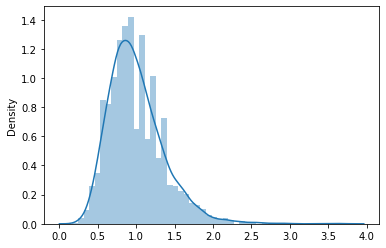

In [16]:
weights = (1./SW.copy()[:len(traindata)]) - 1

weights /= np.mean(weights)
# weights

sns.distplot(weights)

# training

In [17]:
parameters ={'multiply': [['job_duration_in_current_job_level', 'number_of_dependences'],
  ['job_duration_in_current_job_level', 'job_duration_from_training'],
  ['job_duration_in_current_job_level', 'assign_of_otherposition'],
  ['job_duration_in_current_job_level', 'person_level_ordinary'],
  ['job_duration_in_current_person_level', 'job_rotation'],
  ['job_duration_in_current_person_level', 'assign_of_otherposition'],
  ['job_duration_in_current_branch', 'assign_of_otherposition'],
  ['job_duration_in_current_branch', 'annual_leave'],
  ['gender', 'GPA'],
  ['number_of_dependences', 'job_rotation'],
  ['number_of_dependences', 'assign_of_otherposition'],
  ['assign_of_otherposition', 'sick_leaves'],
  ['annual_leave', 'Last_achievement'],
  ['Last_achievement', 'Achievement_above_100_during3quartal'],
  ['Last_achievement', 'person_level_ordinary']],
 'add': [],
 'add_str': [['job_level', 'Employee_type'], ['person_level', 'gender_str']],
 'substract': [],
 'divide': [['job_duration_in_current_job_level', 'person_level_ordinary'],
  ['gender', 'age'],
  ['number_of_dependences', 'branch_rotation'],
  ['number_of_dependences', 'Last_achievement'],
  ['GPA', 'job_duration_from_training'],
  ['branch_rotation', 'Last_achievement'],
  ['job_rotation', 'assign_of_otherposition']],
 'bin_numer_qcut': [['job_duration_in_current_branch', 10]],
 'bin_numer_cut': [['job_duration_in_current_branch', 10], ['GPA', 20]],
 'bin_add_categ_numer_bin_cut': [],
 'bin_add_categ_numer_bin_qcut': [['Employee_type',
   'job_duration_in_current_branch',
   10],
  ['marital_status_maried', 'job_duration_in_current_branch', 10],
  ['Achievement_above_100_during3quartal_str', 'year_graduated', 10],
  ['person_level', 'branch_rotation', 10],
  ['person_level', 'assign_of_otherposition', 10]],
 'bin_target_encoding_cut': [],
 'bin_target_encoding_qcut': [],
 'bin_target_encoding_custom_bin': [],
 'categorical_mean_encoding': [],
 'target': 'Best Performance'}

In [18]:
import warnings
from scipy.optimize.linesearch import LineSearchWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=LineSearchWarning)


add_fes,pipelines,_ = fast_build_model_FE_SW(X_train,y_train,cv,
                    Feature_Engineering,parameters,model_base=LogisticRegression(class_weight='balanced',random_state=random_state,max_iter=10000,C=1,solver='newton-cg'),random_state=random_state,shuffle=True,SW=weights)


Fit iteration 0 done in : 7.868347406387329
Fit iteration 1 done in : 10.284089088439941
Fit iteration 2 done in : 7.676519870758057
Fit iteration 3 done in : 7.989917755126953
Fit iteration 4 done in : 6.940804481506348
Fit iteration 5 done in : 9.497253179550171
Fit iteration 6 done in : 9.439247608184814
Fit iteration 7 done in : 4.909235954284668
Fit iteration 8 done in : 8.388922214508057
Fit iteration 9 done in : 7.557186126708984
Fit iteration 10 done in : 7.147580146789551
Fit iteration 11 done in : 7.046558141708374
Fit iteration 12 done in : 7.9367711544036865
Fit iteration 13 done in : 7.090973138809204
Fit iteration 14 done in : 7.358148097991943
Fit iteration 15 done in : 9.276745796203613
Fit iteration 16 done in : 8.996070861816406
Fit iteration 17 done in : 9.143405199050903
Fit iteration 18 done in : 8.64592432975769
Fit iteration 19 done in : 8.117791414260864
PRec Rec AUC average : [0.87666963 0.18255946] [0.62074401 0.49236408] <==> 0.5871500733228003
[0.55749128919

In [22]:
parameters_fe = {'multiply': [['job_duration_in_current_job_level', 'gender_divide_age'],
  ['GPA', 'job_duration_in_current_branch_times_annual_leave'],
  ['year_graduated',
   'job_duration_in_current_job_level_divide_person_level_ordinary'],
  ['job_duration_from_training', 'number_of_dependences_times_job_rotation'],
  ['branch_rotation', 'assign_of_otherposition_times_sick_leaves'],
  ['assign_of_otherposition',
   'job_duration_in_current_job_level_divide_person_level_ordinary']],
 'add': [],
 'add_str': [['Employee_type',
   'person_level_branch_rotation_bin_add_categ_numer_bin_qcut'],
  ['marital_status_maried',
   'person_level_branch_rotation_bin_add_categ_numer_bin_qcut'],
  ['Education_level',
   'person_level_assign_of_otherposition_bin_add_categ_numer_bin_qcut']],
 'substract': [['job_duration_in_current_job_level',
   'assign_of_otherposition_times_sick_leaves'],
  ['person_level_ordinary', 'gender_divide_age'],
  ['person_level_ordinary', 'GPA_divide_job_duration_from_training']],
 'divide': [],
 'bin_numer_qcut': [['branch_rotation_divide_Last_achievement', 10]],
 'bin_numer_cut': [['person_level_ordinary', 5],
  ['job_duration_in_current_person_level_times_job_rotation', 5]],
 'bin_add_categ_numer_bin_cut': [['person_level_branch_rotation_bin_add_categ_numer_bin_qcut',
   'assign_of_otherposition',
   10],
  ['job_duration_in_current_branch_bin_numer_qcut', 'Last_achievement', 10],
  ['person_level_branch_rotation_bin_add_categ_numer_bin_qcut',
   'Last_achievement',
   10],
  ['person_level_assign_of_otherposition_bin_add_categ_numer_bin_qcut',
   'job_duration_in_current_person_level_times_assign_of_otherposition',
   10],
  ['job_level_plus_Employee_type', 'gender_times_GPA', 10]],
 'bin_add_categ_numer_bin_qcut': [['Achievement_above_100_during3quartal_str',
   'job_duration_in_current_person_level_times_job_rotation',
   10]],
 'bin_target_encoding_cut': [],
 'bin_target_encoding_qcut': [],
 'bin_target_encoding_custom_bin': [],
 'categorical_mean_encoding': [],
 'target': 'Best Performance'}

In [25]:
cv=20
add_fes1,add_fes2,pipelines = fast_build_model_FE_automatic_2_pipe(X_train,y_train,cv,
                    Feature_Engineering,parameters,parameters_fe,model_base=LogisticRegression(class_weight='balanced',random_state=random_state,max_iter=10000,C=1,solver='newton-cg'),random_state=random_state,shuffle=True,SW=weights)

Fit iteration 0 done in : 14.382997035980225
Fit iteration 1 done in : 21.650086164474487
Fit iteration 2 done in : 22.658833026885986
Fit iteration 3 done in : 19.371554613113403
Fit iteration 4 done in : 22.759563207626343
Fit iteration 5 done in : 28.885556936264038
Fit iteration 6 done in : 26.219507932662964
Fit iteration 7 done in : 22.924848556518555
Fit iteration 8 done in : 22.85593891143799
Fit iteration 9 done in : 24.49010157585144
Fit iteration 10 done in : 25.653362274169922
Fit iteration 11 done in : 20.18222451210022
Fit iteration 12 done in : 23.30259943008423
Fit iteration 13 done in : 24.257561445236206
Fit iteration 14 done in : 15.30401611328125
Fit iteration 15 done in : 25.74336528778076
Fit iteration 16 done in : 20.029817581176758
Fit iteration 17 done in : 26.27544593811035
Fit iteration 18 done in : 20.387524604797363
Fit iteration 19 done in : 19.16856598854065
PRec Rec AUC average : [0.87896855 0.18564356] [0.61969315 0.50397068] <==> 0.5918689366820195
0.5

In [35]:
data_shuffle = pd.concat([X_train,y_train],axis=1)
data_shuffle = data_shuffle.sample(frac=1,random_state=random_state)
print(data_shuffle.shape)
X_train_shuffle = data_shuffle.drop(columns=parameters['target'])
y_train_shuffle = data_shuffle[parameters['target']]
add_fes1,add_fes2,pipelines = fast_build_model_FE_2fe_1(X_train_shuffle,y_train_shuffle,
                    Feature_Engineering,parameters,parameters_fe,model_base=LogisticRegression(class_weight='balanced',random_state=0,solver='newton-cg',max_iter=100000),random_state=random_state,shuffle=True,SW=weights[X_train_shuffle.index])


(11153, 27)


In [36]:
pred_proba = fast_predict_FE_2(data_test.copy(),add_fes1,add_fes2,pipelines)

df_submission = pd.DataFrame({'index':data_test.index,'Best Performance':pred_proba})
df_submission

df_submission.to_csv('submission2.csv',index=False)